In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import sonnet as snt

import numpy as np
from bnn.model_utils import *
import matplotlib.pyplot as plt
from cycler import cycler
from bnn.BNN_MLP import *
from bnn.utils import *
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

In [3]:
output_dim = 10
output_mask = tf.Variable(tf.zeros(10), name="mask", trainable=False)
task_labels = [[0,1,2,3,4], [5,6,7,8,9]]
def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = tf.where(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return tf.nn.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
BATCH_SIZE = 64
TRAINING_STEPS = 2001

#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
#mnist2 = permute(mnist,0)
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)
mnist,mnist2 = split_mnist(mnist)

num_batches = (len(mnist.train.labels)//BATCH_SIZE)

X_holder = tf.placeholder(tf.float32, shape=[None, 784])
y_holder = tf.placeholder(tf.float32, shape=[None, 10])


#train_x, train_y = make_tf_data_batch(mnist.train.images, mnist.train.labels)
#test_x, test_y = make_tf_data_batch(mnist.test.images, mnist.test.labels, shuffle=False)

#train_x2, train_y2 = make_tf_data_batch(mnist2.train.images, mnist2.train.labels)
#test_x2, test_y2 = make_tf_data_batch(mnist2.test.images, mnist2.test.labels, shuffle=False)

net = BNN_MLP(n_inputs=784, n_outputs=10, hidden_units=[256, 256], init_mu=0.0, init_rho=-3.0, 
              activation=tf.nn.relu, last_activation=masked_softmax)
net.set_fisher_graph(X_holder,y_holder)
out, log_probs, nll, kl_diver= net(X_holder, targets=y_holder, sample=True, n_samples=1, 
                              loss_function=lambda y, y_target: tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y))

net.set_vanilla_loss(log_probs,nll,num_batches)
net.set_hessian_loss(kl_diver,nll,num_batches)
net.set_uncertain_loss(kl_diver,nll,num_batches)
net.set_kalman_loss(nll)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into 

In [5]:
def train_disjoint(net,sess,num_iters,disp_freq, trainset, testsets, x, y_,lams=[0]):
    acc = np.zeros([len(lams),len(testsets)])

    for l in range(len(lams)):

        if lams[l] == 0:
            continue
            
        net.restore(sess)
        sess.run(net.lams.assign(lams[l]))
        if l == 0:
            train_op = net.train_op
        elif l==1:
            train_op = net.hessian_train_op
            #net.set_ewc_loss(kl_diver,nll,num_batches,lams=lams[l])
        elif l==2:
            train_op = net.uncertain_train_op
        test_accs = []
        
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iters//disp_freq))
        for iters in range(num_iters):
            batch = trainset.train.next_batch(BATCH_SIZE)
            sess.run(train_op,feed_dict={x:batch[0],y_:batch[1]})
            if iters % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                
                for task in range(len(testsets)):
                    set_active_outputs(task_labels[task])
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iters//disp_freq] = sess.run(net.accuracy,feed_dict=feed_dict)
                    acc[l][task] = test_accs[task][iters//disp_freq]
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iters+2,disp_freq), test_accs[task][:iters//disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                '''
                if l == 0 and len(testsets)>1: 
                    plt.title("vanilla sgd,mnist1={:.4f},mnist2={:.4f}".format(acc[l][0],acc[l][1])) 
                elif l==1:
                    plt.title("ewc,mnist1={:.4f},mnist2={:.4f}".format(acc[l][0],acc[l][1]))
                elif l==2:
                    plt.title("uncertainty,mnist1={:.4f},mnist2={:.4f}".format(acc[l][0],acc[l][1]))
                '''
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

                
        #net.compute_fisher(testsets[-1].validation.images,sess,plot_diffs=True)
        #kalman_fisher_merge(sess)
    plt.show()
    
        
    print(np.average(acc,axis=1))
    return np.average(acc,axis=1)

def eval_acc(net,sess,testsets,x,y_):
    acc = 0.0
    for task in range(len(testsets)):
        set_active_outputs(task_labels[task])
        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
        acc += sess.run(net.accuracy,feed_dict=feed_dict)
        #print('MNIST %d Test accuracy : '%task,test_accs)
    return acc / len(testsets)
        


In [6]:
sess = tf.InteractiveSession()
sess.run( tf.global_variables_initializer() )



In [7]:
set_active_outputs(task_labels[0])

In [8]:
#net.set_mask(sess,1)

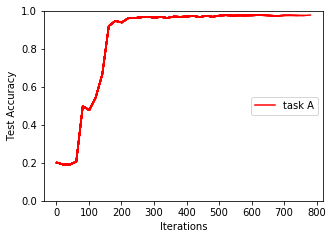

[0.97645456]


array([0.97645456])

In [9]:
#train_place(net,sess,800,20,mnist,[mnist],X_holder,y_holder,lams=[0.1])
train_disjoint(net,sess,800,20,mnist,[mnist],X_holder,y_holder,lams=[0.1])

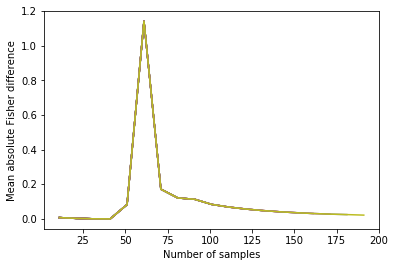

In [10]:
net.store()
net.set_prior(sess)
#net.set_kalman_params(sess)
net.compute_fisher(mnist.validation.images,sess,plot_diffs=True)
#net.store_fisher()

In [11]:
#print(tf.log(1 + tf.exp(net.start_uncertain_list[4])).eval())

In [12]:
#print(net.kalman_uncertain[4])

In [13]:
set_active_outputs(task_labels[1])

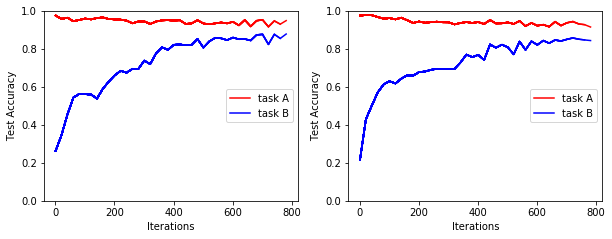

[0.91182002 0.87781039]


In [14]:
#net.set_mask(sess,2)
#net.set_prior(sess)
acc = train_disjoint(net,sess,800,20,mnist2,[mnist,mnist2]
                                                     ,X_holder,y_holder,lams=[0.1,0.1])

KeyboardInterrupt: 

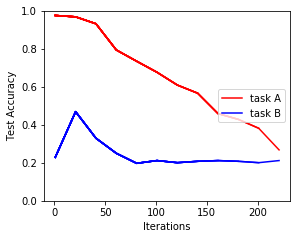

In [15]:
acc = train_disjoint(net,sess,800,20,mnist2,[mnist,mnist2]
                                                     ,X_holder,y_holder,lams=[0,0,0.1])

In [ ]:
net.compute_fisher(mnist2.validation.images,sess,plot_diffs=True)
net.set_kalman_params(sess)

In [ ]:
best_acc = 0.0
best_alpha = 0.0
for alpha in np.linspace(0,1):
    net.dist_mean_merge(sess,alpha)
    acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
print(best_acc,best_alpha)

In [ ]:
best_acc = 0.0
best_alpha = 0.0
for alpha in np.linspace(0,1):
    net.dist_fisher_merge(sess,alpha)
    acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
print(best_acc,best_alpha)

In [ ]:
#train_place(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0.1])
best_acc1 = 0
best_l1 = 0
best_acc2 = 0
best_l2 = 0
best_kal_acc1 = 0
best_kal_acc2 = 0
best_kal_l1 = 0
best_kal_l2 = 0
for l in [0.1,0.01]:#np.linspace(10**-4,0.11):
    acc = train_disjoint(net,sess,800,20,mnist2,[mnist,mnist2]
                                                     ,X_holder,y_holder,lams=[l])
    
    net.compute_fisher(mnist2.validation.images,sess,plot_diffs=True)
    net.kalman_fisher_merge(sess)
    kal_acc = eval_acc(net,sess,[mnist,mnist2],X_holder,y_holder)

    if acc> best_acc1:
        best_acc1 = acc
        best_l1 = l
    #if acc2>best_acc2:
     #   best_acc2 = acc2
     #   best_l2 = l
    if kal_acc > best_kal_acc1:
        best_kal_acc1 = kal_acc
        best_kal_l1 = l
    #if kal_acc2 > best_kal_acc2:
    #    best_kal_acc2 = kal_acc2
     #   best_kal_l2 = l   
        

In [ ]:
#print(net.layers[1].b_prior_mean.eval())

In [ ]:
print(best_l1,best_kal_l1)

In [ ]:
print(best_acc1,best_acc2,best_kal_acc1,best_kal_acc2)

In [ ]:
#net.set_prior(sess)

In [ ]:
#train_place(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[500,700])
train_disjoint(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0.1,0,0.1])

In [ ]:
#train_place(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0.1])
#train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[500,500,500])

In [ ]:
#net.compute_fisher(mnist.validation.images,sess,plot_diffs=True)

In [ ]:
train_disjoint(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0.01,0,0.01])

In [ ]:
#train_place(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[20])
train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0,0,0.001])

In [ ]:
#train_place(net,sess,800,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[1000])
#train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0,1000,0])
train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0,0,0.005])

In [ ]:
#train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0.0001,0.0001,0.0001])
train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0,0,0.000005])

In [ ]:
#train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0,10000,10])

In [ ]:
#print(net.start_uncertain_list)
#print(net.star_mask_list[4].astype(np.float32))

In [ ]:
#train_disjoint(net,sess,2000,20,mnist2,[mnist,mnist2],X_holder,y_holder,lams=[0,10**7,0.01])

In [ ]:
print(net.start_uncertain_list)